In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import f1_score
import optuna
import matplotlib.pyplot as plt
from colorama import Fore, Style
import warnings
from tqdm import tqdm

np.random.seed = 42
optuna.logging.set_verbosity(0)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('data/train.csv').rename({'DEBT': 'target'}, axis=1)
submit = pd.read_csv('data/sample_submission.csv')
disc = pd.read_csv('data/comp_disc.csv')
marks = pd.read_csv('data/comp_marks.csv')
portrait = pd.read_csv('data/comp_portrait.csv')
students = pd.read_csv('data/comp_students.csv', date_parser='DATE_START')
teachers = pd.read_csv('data/comp_teachers.csv')
test = pd.read_csv('data/test.csv')

In [3]:
all_dicts = {}
all_dicts['student_id'] = LabelEncoder().fit(portrait['ISU'])
for x in [marks, train, students, portrait, test]:
    x['ISU'] = all_dicts['student_id'].transform(x['ISU'])
for x in [marks, train, students, portrait, test]:
    x.rename({'ISU': 'student_id'}, axis=1, inplace=True)

all_dicts['disc_id'] = LabelEncoder().fit(np.concatenate((teachers['DISC_ID'].unique(),disc['DISC_ID'].unique(), test['DISC_ID'].unique())))
for x in [train, disc, teachers, marks, test]:
    x['DISC_ID'] = all_dicts['disc_id'].transform(x['DISC_ID'])

all_dicts['plan'] = LabelEncoder().fit(np.concatenate((disc['PLAN_ID'].unique(),students['MAIN_PLAN'].unique())))
disc['PLAN_ID'] = all_dicts['plan'].transform(disc['PLAN_ID'])
for x in [marks, students, teachers]:
    x['MAIN_PLAN'] = all_dicts['plan'].transform(x['MAIN_PLAN'])

all_dicts['teacher'] = LabelEncoder().fit(np.concatenate((teachers['ISU'].unique(), marks['PRED_ID'].unique())))
teachers['ISU'] = all_dicts['teacher'].transform(teachers['ISU'])
marks['PRED_ID'] = all_dicts['teacher'].transform(marks['PRED_ID'])

all_dicts['type_name'] = LabelEncoder().fit(train['TYPE_NAME'])
train['TYPE_NAME'] = all_dicts['type_name'].transform(train['TYPE_NAME'])
test['TYPE_NAME'] = all_dicts['type_name'].transform(test['TYPE_NAME'])

all_dicts['gender'] = LabelEncoder().fit(portrait['GENDER'])
portrait['GENDER'] = all_dicts['gender'].transform(portrait['GENDER'])

all_dicts['exam_type'] = LabelEncoder().fit(portrait['EXAM_TYPE'])
portrait['EXAM_TYPE'] = all_dicts['exam_type'].transform(portrait['EXAM_TYPE'])

train['SEM+DISC+TYPE'] = train['SEMESTER'].astype('str')+'_'+train['DISC_ID'].astype('str')+'_'+train['TYPE_NAME'].astype('str')
test['SEM+DISC+TYPE'] = test['SEMESTER'].astype('str')+'_'+test['DISC_ID'].astype('str')+'_'+test['TYPE_NAME'].astype('str')
train['student+TYPE'] = train['student_id'].astype('str')+'_'+train['TYPE_NAME'].astype('str')
test['student+TYPE'] = test['student_id'].astype('str')+'_'+test['TYPE_NAME'].astype('str')
train['student+DISC'] = train['student_id'].astype('str')+'_'+train['DISC_ID'].astype('str')
test['student+DISC'] = test['student_id'].astype('str')+'_'+test['DISC_ID'].astype('str')
train['DISC+TYPE'] = train['DISC_ID'].astype('str')+'_'+train['TYPE_NAME'].astype('str')
test['DISC+TYPE'] = test['DISC_ID'].astype('str')+'_'+test['TYPE_NAME'].astype('str')
train['DISC+SEMESTER'] = train['DISC_ID'].astype('str')+'_'+train['SEMESTER'].astype('str')
test['DISC+SEMESTER'] = test['DISC_ID'].astype('str')+'_'+test['SEMESTER'].astype('str')

marks['MARK'] = marks['MARK'].replace({'зачет': '5', 'неявка': '2', 'незач': '2', 'осв': '3'})
train['MARK'] = train['MARK'].replace({'зачет': '5', 'неявка': '2', 'незач': '2', 'осв': '3'})
train.loc[~train['MARK'].isna(), 'MARK'] = train.loc[~train['MARK'].isna(), 'MARK'].astype('int')

teachers = teachers[~teachers['MARK'].isna()]
teachers['ST_YEAR'] = teachers['ST_YEAR'].apply(lambda x: x[:4])
teachers['DISC+SEMESTER'] = teachers['DISC_ID'].astype('str')+'_'+teachers['SEMESTER'].astype('int').astype('str')

In [4]:
data = train[train['ST_YEAR']!=2020]
data_teachers = teachers[teachers['ST_YEAR']!='2020']
for_training = train[(train['ST_YEAR']==2020)&(train['student_id'].isin(data['student_id']))]

In [5]:
students_info = data.groupby('student_id')[['target', 'MARK']].agg(['mean'])
students_info.columns = [f"student_{x[0]}_{x[1]}" for x in students_info.columns]

student_disc_info = data.groupby('student+DISC')[['target', 'MARK']].agg(['mean'])
student_disc_info.columns = [f"student_disc_{x[0]}_{x[1]}" for x in student_disc_info.columns]

disc_full_info = data.groupby('SEM+DISC+TYPE')[['MARK', 'target']].agg(['mean'])
disc_full_info.columns = [f"sem_disc_type_{x[0]}_{x[1]}" for x in disc_full_info.columns]

disc_info = data.groupby('DISC_ID')[['MARK', 'target']].agg(['mean'])
disc_info.columns = [f"disc_{x[0]}_{x[1]}" for x in disc_info.columns]

disc_sem_teachers = data_teachers.groupby('DISC+SEMESTER')['MARK'].agg(['mean'])
disc_sem_teachers.columns = ['avg_mark_disc_sem_teachers']

In [6]:
avg_marks_1_sem = data[data['SEMESTER']==1].groupby('student_id')[['MARK', 'target']].agg(['mean'])
avg_marks_1_sem.columns = [f"marks_1_sem_{x[0]}_{x[1]}" for x in avg_marks_1_sem.columns]
avg_marks_2_sem = data[data['SEMESTER']==2].groupby('student_id')[['MARK', 'target']].agg(['mean'])
avg_marks_2_sem.columns = [f"marks_2_sem_{x[0]}_{x[1]}" for x in avg_marks_2_sem.columns]
avg_marks_3_sem = data[data['SEMESTER']==3].groupby('student_id')[['MARK', 'target']].agg(['mean'])
avg_marks_3_sem.columns = [f"marks_3_sem_{x[0]}_{x[1]}" for x in avg_marks_3_sem.columns]
avg_marks_4_sem = data[data['SEMESTER']==4].groupby('student_id')[['MARK', 'target']].agg(['mean'])
avg_marks_4_sem.columns = [f"marks_4_sem_{x[0]}_{x[1]}" for x in avg_marks_4_sem.columns]

for_training = for_training.merge(avg_marks_1_sem, how='left', left_on='student_id', right_index=True).merge(
                                    avg_marks_2_sem, how='left', left_on='student_id', right_index=True).merge(
                                        avg_marks_3_sem, how='left', left_on='student_id', right_index=True).merge(
                                            avg_marks_4_sem, how='left', left_on='student_id', right_index=True)

data = data.merge(students_info, how='left', left_on='student_id', right_index=True).merge(
                            disc_info, how='left', left_on='DISC_ID', right_index=True).merge(
                                disc_full_info, how='left', left_on='SEM+DISC+TYPE', right_index=True)

for_training = for_training.merge(students_info, how='left', left_on='student_id', right_index=True).merge(
                                    student_disc_info, how='left', left_on='student+DISC', right_index=True).merge(
                                        disc_info, how='left', left_on='DISC_ID', right_index=True).merge(
                                            disc_sem_teachers, how='left', left_on='DISC+SEMESTER', right_index=True).merge(
                                                disc_full_info, how='left', left_on='SEM+DISC+TYPE', right_index=True)
del students_info, disc_info, disc_full_info

disc_bad_stud_info = data[data['target']==1].groupby('SEM+DISC+TYPE')[['student_target_mean', 'student_MARK_mean']].agg(['mean'])
disc_bad_stud_info.columns = [f"disc_bad_stud_{x[0]}_{x[1]}" for x in disc_bad_stud_info]
disc_good_stud_info = data[data['target']==0].groupby('SEM+DISC+TYPE')[['student_target_mean', 'student_MARK_mean']].agg(['mean'])
disc_good_stud_info.columns = [f"disc_good_stud_{x[0]}_{x[1]}" for x in disc_good_stud_info]

student_disc_bad_info = data[data['target']==1].groupby('student_id')[['disc_MARK_mean', 'disc_target_mean']].agg(['mean'])
student_disc_bad_info.columns = [f"student_disc_bad_info_{x[0]}_{x[1]}" for x in student_disc_bad_info.columns]
student_disc_good_info = data[data['target']==0].groupby('student_id')[['disc_MARK_mean', 'disc_target_mean']].agg(['mean'])
student_disc_good_info.columns = [f"student_disc_good_info_{x[0]}_{x[1]}" for x in student_disc_good_info.columns]

for_training = for_training.merge(disc_bad_stud_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                    disc_good_stud_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                        student_disc_bad_info, how='left', left_on='student_id', right_index=True).merge(
                                            student_disc_good_info, how='left', left_on='student_id', right_index=True)
del disc_good_stud_info, disc_bad_stud_info, student_disc_bad_info, student_disc_good_info

In [7]:
train_data = for_training.drop(['student_id', 'ST_YEAR', 'SEMESTER', 'DISC_ID', 'MARK', 'SEM+DISC+TYPE', 'DISC+TYPE', 'student+TYPE', 'student+DISC', 'DISC+SEMESTER'], axis=1)
features = train_data.drop('target', axis=1)
target = train_data['target']

model = CatBoostClassifier(
    depth=5,
    iterations=3000,
    eval_metric='F1',
    random_seed=42,
    early_stopping_rounds=2000
)

model.fit(Pool(features, target, cat_features=['TYPE_NAME']), verbose=200)
feature_imp = pd.DataFrame({'feature_imp': model.get_feature_importance(), 'feature': features.columns}).sort_values('feature_imp', ascending=False)
feature_imp

Learning rate set to 0.021015
0:	learn: 0.1108987	total: 74.7ms	remaining: 3m 43s
200:	learn: 0.1936389	total: 2.71s	remaining: 37.7s
400:	learn: 0.2972735	total: 5.27s	remaining: 34.2s
600:	learn: 0.3582594	total: 7.89s	remaining: 31.5s
800:	learn: 0.4067241	total: 10.3s	remaining: 28.2s
1000:	learn: 0.4294923	total: 12.8s	remaining: 25.7s
1200:	learn: 0.4595341	total: 15.4s	remaining: 23s
1400:	learn: 0.4795640	total: 17.9s	remaining: 20.4s
1600:	learn: 0.4982752	total: 20.1s	remaining: 17.6s
1800:	learn: 0.5106707	total: 22.4s	remaining: 14.9s
2000:	learn: 0.5250849	total: 24.7s	remaining: 12.3s
2200:	learn: 0.5409040	total: 27s	remaining: 9.79s
2400:	learn: 0.5490342	total: 29.2s	remaining: 7.29s
2600:	learn: 0.5578986	total: 31.5s	remaining: 4.83s
2800:	learn: 0.5666179	total: 33.8s	remaining: 2.4s
2999:	learn: 0.5747460	total: 36.1s	remaining: 0us


,feature_imp,feature
10,19.286449,student_MARK_mean
3,12.947083,marks_2_sem_MARK_mean
24,12.377116,student_disc_good_info_disc_MARK_mean_mean
25,10.042697,student_disc_good_info_disc_target_mean_mean
1,6.229841,marks_1_sem_MARK_mean
7,5.308893,marks_4_sem_MARK_mean
5,5.116960,marks_3_sem_MARK_mean
12,4.212737,student_disc_MARK_mean
19,2.547994,disc_bad_stud_student_MARK_mean_mean
23,2.443155,student_disc_bad_info_disc_target_mean_mean


In [8]:
features

,TYPE_NAME,marks_1_sem_MARK_mean,marks_1_sem_target_mean,marks_2_sem_MARK_mean,marks_2_sem_target_mean,marks_3_sem_MARK_mean,marks_3_sem_target_mean,marks_4_sem_MARK_mean,marks_4_sem_target_mean,student_target_mean,...,sem_disc_type_MARK_mean,sem_disc_type_target_mean,disc_bad_stud_student_target_mean_mean,disc_bad_stud_student_MARK_mean_mean,disc_good_stud_student_target_mean_mean,disc_good_stud_student_MARK_mean_mean,student_disc_bad_info_disc_MARK_mean_mean,student_disc_bad_info_disc_target_mean_mean,student_disc_good_info_disc_MARK_mean_mean,student_disc_good_info_disc_target_mean_mean
0,1,4.200000,0.0,3.6,0.2,NaN,NaN,NaN,NaN,0.1,...,4.892857,0.035714,0.454545,3.454545,0.035975,4.518332,3.803398,0.068182,4.469118,0.049939
1,1,4.200000,0.0,3.6,0.2,NaN,NaN,NaN,NaN,0.1,...,4.852194,0.048669,0.860039,2.323325,0.061309,4.376699,3.803398,0.068182,4.469118,0.049939
2,1,4.200000,0.0,3.6,0.2,NaN,NaN,NaN,NaN,0.1,...,4.709677,0.092754,0.497602,3.282618,0.030530,4.472332,3.803398,0.068182,4.469118,0.049939
3,1,4.200000,0.0,3.6,0.2,NaN,NaN,NaN,NaN,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,3.803398,0.068182,4.469118,0.049939
4,3,4.200000,0.0,3.6,0.2,NaN,NaN,NaN,NaN,0.1,...,4.390173,0.048711,0.676583,2.871372,0.038976,4.444777,3.803398,0.068182,4.469118,0.049939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179181,1,4.312500,0.0,4.6,0.0,NaN,NaN,NaN,NaN,0.0,...,4.924312,0.025229,0.173453,4.004497,0.003500,4.631350,NaN,NaN,4.147860,0.060345
179182,1,4.312500,0.0,4.6,0.0,NaN,NaN,NaN,NaN,0.0,...,4.775758,0.074747,0.264092,3.613340,0.008915,4.598947,NaN,NaN,4.147860,0.060345
179185,3,4.222222,0.0,4.6,0.0,4.363636,0.0,4.444444,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.673527,0.028298
179186,1,4.300000,0.0,3.9,0.0,4.600000,0.0,4.777778,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.431343,0.050391


In [9]:
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
scores = []
preds = np.zeros((len(for_training)))
for fold, (train_index, valid_index) in enumerate(strat_kfold.split(features, target)):
    X_train, y_train = features.iloc[train_index], target.iloc[train_index]
    X_valid, y_valid = features.iloc[valid_index], target.iloc[valid_index]
    model = CatBoostClassifier(
        depth=5,
        iterations=3000,
        eval_metric='F1',
        random_seed=42,
        early_stopping_rounds=2000,
        #logging_level='Silent'
    )
    model.fit(Pool(X_train, y_train, cat_features=['TYPE_NAME']), eval_set=Pool(X_valid, y_valid, cat_features=['TYPE_NAME']), verbose=1000)
    models.append(model)
    scores.append(f1_score(y_valid, model.predict(X_valid)))
    preds[valid_index] = model.predict(X_valid)

    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} Score = {f1_score(y_valid, model.predict(X_valid)):.5f} {f1_score(y_valid, (model.predict_proba(X_valid)[:, 1]>0.4).astype('int')):.5f}  {f1_score(y_valid, (model.predict_proba(X_valid)[:, 1]>0.3).astype('int')):.5f}  {f1_score(y_valid, (model.predict_proba(X_valid)[:, 1]>0.2).astype('int')):.5f}{Style.RESET_ALL}",)
        
print(f"{Fore.RED}{Style.BRIGHT}OOF Score:   {np.mean(scores):.5f}{Style.RESET_ALL}")

Learning rate set to 0.050303
0:	learn: 0.0655130	test: 0.0681265	best: 0.0681265 (0)	total: 11.5ms	remaining: 34.6s
1000:	learn: 0.5740486	test: 0.4038462	best: 0.4046243 (989)	total: 11s	remaining: 21.9s
2000:	learn: 0.6532534	test: 0.4510166	best: 0.4538745 (1866)	total: 22.2s	remaining: 11.1s
2999:	learn: 0.7117671	test: 0.4651163	best: 0.4651163 (2992)	total: 33.7s	remaining: 0us

bestTest = 0.4651162791
bestIteration = 2992

Shrink model to first 2993 iterations.
Fold 0 Score = 0.46512 0.48860  0.52212  0.54408
Learning rate set to 0.050303
0:	learn: 0.0208062	test: 0.0208877	best: 0.0208877 (0)	total: 12.7ms	remaining: 38s
1000:	learn: 0.5687989	test: 0.4291188	best: 0.4346154 (797)	total: 11.5s	remaining: 23s
2000:	learn: 0.6368813	test: 0.4643510	best: 0.4680073 (1878)	total: 22.6s	remaining: 11.3s
2999:	learn: 0.6921141	test: 0.4849558	best: 0.4876325 (2619)	total: 33.7s	remaining: 0us

bestTest = 0.4876325088
bestIteration = 2619

Shrink model to first 2620 iterations.
Fold 

0.21855

In [10]:
for_training['prediction'] = preds

In [11]:
a = np.zeros(len(X_train.columns))
for model in models: a += model.get_feature_importance()
a /= len(models)
pd.DataFrame({'x': a, 'y': X_train.columns}).sort_values('x', ascending=False)

,x,y
10,18.132785,student_MARK_mean
24,12.668692,student_disc_good_info_disc_MARK_mean_mean
3,11.615498,marks_2_sem_MARK_mean
25,11.292754,student_disc_good_info_disc_target_mean_mean
1,6.789493,marks_1_sem_MARK_mean
5,5.346458,marks_3_sem_MARK_mean
7,5.317165,marks_4_sem_MARK_mean
12,3.780383,student_disc_MARK_mean
19,2.913344,disc_bad_stud_student_MARK_mean_mean
0,2.516049,TYPE_NAME


In [12]:
test_part = test.copy(deep=True)
data = train.copy(deep=True)
data_teachers = teachers

students_info = data.groupby('student_id')[['target', 'MARK']].agg(['mean'])
students_info.columns = [f"student_{x[0]}_{x[1]}" for x in students_info.columns]
student_disc_info = data.groupby('student+DISC')[['target', 'MARK']].agg(['mean'])
student_disc_info.columns = [f"student_disc_{x[0]}_{x[1]}" for x in student_disc_info.columns]
disc_full_info = data.groupby('SEM+DISC+TYPE')[['MARK', 'target']].agg(['mean'])
disc_full_info.columns = [f"sem_disc_type_{x[0]}_{x[1]}" for x in disc_full_info.columns]
disc_info = data.groupby('DISC_ID')[['MARK', 'target']].agg(['mean'])
disc_info.columns = [f"disc_{x[0]}_{x[1]}" for x in disc_info.columns]
disc_sem_teachers = data_teachers.groupby('DISC+SEMESTER')['MARK'].agg(['mean'])
disc_sem_teachers.columns = ['avg_mark_disc_sem_teachers']

avg_marks_1_sem = data[data['SEMESTER']==1].groupby('student_id')[['MARK', 'target']].agg(['mean'])
avg_marks_1_sem.columns = [f"marks_1_sem_{x[0]}_{x[1]}" for x in avg_marks_1_sem.columns]
avg_marks_2_sem = data[data['SEMESTER']==2].groupby('student_id')[['MARK', 'target']].agg(['mean'])
avg_marks_2_sem.columns = [f"marks_2_sem_{x[0]}_{x[1]}" for x in avg_marks_2_sem.columns]
avg_marks_3_sem = data[data['SEMESTER']==3].groupby('student_id')[['MARK', 'target']].agg(['mean'])
avg_marks_3_sem.columns = [f"marks_3_sem_{x[0]}_{x[1]}" for x in avg_marks_3_sem.columns]
avg_marks_4_sem = data[data['SEMESTER']==4].groupby('student_id')[['MARK', 'target']].agg(['mean'])
avg_marks_4_sem.columns = [f"marks_4_sem_{x[0]}_{x[1]}" for x in avg_marks_4_sem.columns]

test_part = test_part.merge(avg_marks_1_sem, how='left', left_on='student_id', right_index=True).merge(
                                    avg_marks_2_sem, how='left', left_on='student_id', right_index=True).merge(
                                        avg_marks_3_sem, how='left', left_on='student_id', right_index=True).merge(
                                            avg_marks_4_sem, how='left', left_on='student_id', right_index=True)

data = data.merge(students_info, how='left', left_on='student_id', right_index=True).merge(
                    disc_info, how='left', left_on='DISC_ID', right_index=True).merge(
                        disc_full_info, how='left', left_on='SEM+DISC+TYPE', right_index=True)

test_part = test_part.merge(students_info, how='left', left_on='student_id', right_index=True).merge(
                                    student_disc_info, how='left', left_on='student+DISC', right_index=True).merge(
                                        disc_info, how='left', left_on='DISC_ID', right_index=True).merge(
                                            disc_sem_teachers, how='left', left_on='DISC+SEMESTER', right_index=True).merge(
                                                disc_full_info, how='left', left_on='SEM+DISC+TYPE', right_index=True)
                                        
del students_info, disc_info, disc_full_info

disc_bad_stud_info = data[data['target']==1].groupby('SEM+DISC+TYPE')[['student_target_mean', 'student_MARK_mean']].agg(['mean'])
disc_bad_stud_info.columns = [f"disc_bad_stud_{x[0]}_{x[1]}" for x in disc_bad_stud_info]
disc_good_stud_info = data[data['target']==0].groupby('SEM+DISC+TYPE')[['student_target_mean', 'student_MARK_mean']].agg(['mean'])
disc_good_stud_info.columns = [f"disc_good_stud_{x[0]}_{x[1]}" for x in disc_good_stud_info]

student_disc_bad_info = data[data['target']==1].groupby('student_id')[['disc_MARK_mean', 'disc_target_mean']].agg(['mean'])
student_disc_bad_info.columns = [f"student_disc_bad_info_{x[0]}_{x[1]}" for x in student_disc_bad_info.columns]
student_disc_good_info = data[data['target']==0].groupby('student_id')[['disc_MARK_mean', 'disc_target_mean']].agg(['mean'])
student_disc_good_info.columns = [f"student_disc_good_info_{x[0]}_{x[1]}" for x in student_disc_good_info.columns]

test_part = test_part.merge(disc_bad_stud_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                    disc_good_stud_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                        student_disc_bad_info, how='left', left_on='student_id', right_index=True).merge(
                                            student_disc_good_info, how='left', left_on='student_id', right_index=True)
del disc_bad_stud_info, disc_good_stud_info, student_disc_bad_info, student_disc_good_info

In [13]:
test_part = test_part.loc[test_part['student_id'].isin(train['student_id'])].drop(['student_id', 'ST_YEAR', 'SEMESTER', 'DISC_ID', 'SEM+DISC+TYPE', 'student+TYPE', 'student+DISC', 'DISC+SEMESTER', 'DISC+TYPE'], axis=1)

In [14]:
test_part

,TYPE_NAME,marks_1_sem_MARK_mean,marks_1_sem_target_mean,marks_2_sem_MARK_mean,marks_2_sem_target_mean,marks_3_sem_MARK_mean,marks_3_sem_target_mean,marks_4_sem_MARK_mean,marks_4_sem_target_mean,student_target_mean,...,sem_disc_type_MARK_mean,sem_disc_type_target_mean,disc_bad_stud_student_target_mean_mean,disc_bad_stud_student_MARK_mean_mean,disc_good_stud_student_target_mean_mean,disc_good_stud_student_MARK_mean_mean,student_disc_bad_info_disc_MARK_mean_mean,student_disc_bad_info_disc_target_mean_mean,student_disc_good_info_disc_MARK_mean_mean,student_disc_good_info_disc_target_mean_mean
0,3,4.7,0.0,4.6,0.0,NaN,NaN,NaN,NaN,0.0,...,3.857664,0.009124,0.064108,4.067075,0.013774,4.545898,NaN,NaN,4.382533,0.064489
1,1,4.7,0.0,4.6,0.0,NaN,NaN,NaN,NaN,0.0,...,4.845556,0.051481,0.259001,3.658300,0.015033,4.585359,NaN,NaN,4.382533,0.064489
2,1,4.7,0.0,4.6,0.0,NaN,NaN,NaN,NaN,0.0,...,4.929619,0.005848,0.207646,3.787856,0.010086,4.626902,NaN,NaN,4.382533,0.064489
3,1,4.7,0.0,4.6,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.382533,0.064489
4,1,4.7,0.0,4.6,0.0,NaN,NaN,NaN,NaN,0.0,...,5.000000,0.000000,NaN,NaN,0.017669,4.471946,NaN,NaN,4.382533,0.064489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36244,1,5.0,0.0,4.8,0.0,5.0,0.0,4.818182,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.580266,0.038455
36245,1,5.0,0.0,4.8,0.0,5.0,0.0,4.818182,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.580266,0.038455
36246,1,5.0,0.0,4.8,0.0,5.0,0.0,4.818182,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.580266,0.038455
36247,3,5.0,0.0,4.8,0.0,5.0,0.0,4.818182,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.580266,0.038455


In [15]:
preds = np.zeros(len(test_part))
for model in models:
    preds += model.predict_proba(test_part)[:, 1]
preds /= len(models)

In [27]:
submit.loc[test['student_id'].isin(train['student_id']), 'DEBT'] = (preds > 0.21).astype('int')
pd.DataFrame({'x': (preds > 0.21).astype('int')})['x'].value_counts()

0    29222
1     1798
Name: x, dtype: int64

<h3>СТУДЕНТЫ БЕЗ ИНФЫ</h3>

In [28]:
data = train[train['ST_YEAR']!=2020]
data_teachers = teachers[teachers['ST_YEAR']!='2020']
for_training = train[(train['ST_YEAR']==2020)&(~train['student_id'].isin(data['student_id']))]

<AxesSubplot:>

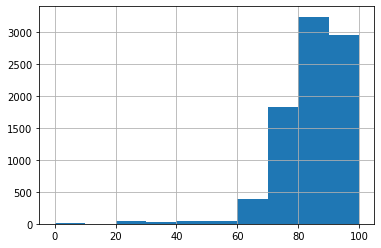

In [29]:
portrait['SUM'] = portrait['ADMITTED_EXAM_1']+portrait['ADMITTED_EXAM_2']+portrait['ADMITTED_EXAM_3']
portrait['COUNT_EXAMS'] = (~portrait['ADMITTED_EXAM_1'].isna()).astype('int') + (~portrait['ADMITTED_EXAM_2'].isna()).astype('int') + (~portrait['ADMITTED_EXAM_3'].isna()).astype('int')
portrait.loc[portrait['COUNT_EXAMS']!=0, 'EXAMS_MEAN'] = portrait.loc[portrait['COUNT_EXAMS']!=0, 'SUM'] / portrait.loc[portrait['COUNT_EXAMS']!=0, 'COUNT_EXAMS']
portrait.loc[portrait['COUNT_EXAMS']==0, 'EXAMS_MEAN'] = 100
portrait['EXAMS_MEAN'].hist()

In [30]:
data = data.merge(portrait[['student_id', 'EXAM_TYPE', 'EXAMS_MEAN']], how='left', left_on='student_id', right_on='student_id')

disc_full_info = data.groupby('SEM+DISC+TYPE')[['MARK', 'target', 'EXAMS_MEAN']].agg(['mean'])
disc_full_info.columns = [f"sem_disc_type_{x[0]}_{x[1]}" for x in disc_full_info.columns]

disc_full_bad_info = data[data['target']==1].groupby('SEM+DISC+TYPE')[['EXAMS_MEAN']].agg(['mean'])
disc_full_bad_info.columns = [f"disc_full_bad" for x in disc_full_bad_info.columns]

disc_info = data.groupby('DISC_ID')[['MARK', 'target', 'EXAMS_MEAN']].agg(['mean'])
disc_info.columns = [f"disc_{x[0]}_{x[1]}" for x in disc_info.columns]

In [31]:
# # Инфа о таких работах на дисциплине
# disc_type_info = data.groupby('DISC+TYPE')[['MARK', 'target', 'EXAMS_MEAN']].agg(['mean'])
# disc_type_info.columns = [f'disc_type_{x[0]}_{x[1]}' for x in disc_type_info.columns]

# # Инфа о семестре и дисциплине
# disc_sem_info = data.groupby('DISC+SEMESTER')[['MARK', 'target', 'EXAMS_MEAN']].agg(['mean'])
# disc_sem_info.columns = [f'disc_semester_{x[0]}_{x[1]}' for x in disc_sem_info.columns]

# Инфа о средней оценке по дисциплине и семестру
avg_mark_disc_sem = data_teachers.groupby('DISC+SEMESTER')['MARK'].agg(['mean'])
avg_mark_disc_sem.columns = [f"avg_mark_disc_mean"]

for_training = for_training.merge(disc_info, how='left', left_on='DISC_ID', right_index=True).merge(
                                    disc_full_bad_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                        disc_full_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                            avg_mark_disc_sem, how='left', left_on='DISC+SEMESTER', right_index=True).merge(
                                                portrait[['student_id', 'EXAMS_MEAN', 'EXAM_TYPE', 'COUNT_EXAMS']], how='left', left_on='student_id', right_on='student_id')
del disc_info, disc_full_bad_info, disc_full_info
for_training

,student_id,ST_YEAR,SEMESTER,DISC_ID,TYPE_NAME,MARK,target,SEM+DISC+TYPE,student+TYPE,student+DISC,...,disc_target_mean,disc_EXAMS_MEAN_mean,disc_full_bad,sem_disc_type_MARK_mean,sem_disc_type_target_mean,sem_disc_type_EXAMS_MEAN_mean,avg_mark_disc_mean,EXAMS_MEAN,EXAM_TYPE,COUNT_EXAMS
0,6448,2020,1,3913,1,5,0,1_3913_1,6448_1,6448_3913,...,0.033803,95.600939,85.750000,4.892351,0.033803,95.600939,3.000000,96.000000,1,3
1,2497,2020,1,1359,1,5,0,1_1359_1,2497_1,2497_1359,...,0.027119,82.990395,74.400000,4.900000,0.031746,82.515344,4.000000,89.666667,1,3
2,7606,2020,1,1212,0,3,0,1_1212_0,7606_0,7606_1212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,2,0
3,2462,2020,1,1212,0,5,0,1_1212_0,2462_0,2462_1212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.666667,1,3
4,1790,2020,1,1212,0,3,0,1_1212_0,1790_0,1790_1212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.666667,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31498,5264,2020,2,2131,3,5,0,2_2131_3,5264_3,5264_2131,...,0.088303,86.143349,82.654321,3.836317,0.067839,86.724456,3.809250,91.666667,1,3
31499,5264,2020,1,2131,1,5,0,1_2131_1,5264_1,5264_2131,...,0.088303,86.143349,78.740000,4.676660,0.105485,85.655415,3.600000,91.666667,1,3
31500,5264,2020,2,3513,1,5,0,2_3513_1,5264_1,5264_3513,...,0.049633,84.434038,82.698551,4.849015,0.049633,84.434038,NaN,91.666667,1,3
31501,5264,2020,2,464,3,5,0,2_464_3,5264_3,5264_464,...,0.125000,85.387610,83.396396,3.574074,0.132379,85.914729,3.562357,91.666667,1,3


In [32]:
train_data = for_training.drop(['student_id', 'ST_YEAR', 'SEMESTER', 'DISC_ID', 'MARK', 'SEM+DISC+TYPE', 'DISC+TYPE', 'student+TYPE', 'student+DISC', 'DISC+SEMESTER'], axis=1)
features = train_data.drop('target', axis=1)
target = train_data['target']

model = CatBoostClassifier(
    depth=5,
    iterations=2000,
    eval_metric='F1',
    random_seed=42,
    early_stopping_rounds=2000
)
model.fit(Pool(features, target, cat_features=['TYPE_NAME', 'EXAM_TYPE']), verbose=200)
feature_imp = pd.DataFrame({'feature_imp': model.get_feature_importance(), 'feature': features.columns}).sort_values('feature_imp', ascending=False)
feature_imp

Learning rate set to 0.023806
0:	learn: 0.0000000	total: 7.38ms	remaining: 14.7s
200:	learn: 0.0259459	total: 1.96s	remaining: 17.5s
400:	learn: 0.0438268	total: 3.84s	remaining: 15.3s
600:	learn: 0.0675462	total: 5.92s	remaining: 13.8s
800:	learn: 0.0966234	total: 7.78s	remaining: 11.7s
1000:	learn: 0.1034126	total: 9.69s	remaining: 9.68s
1200:	learn: 0.1149897	total: 11.6s	remaining: 7.71s
1400:	learn: 0.1235955	total: 13.4s	remaining: 5.74s
1600:	learn: 0.1329949	total: 15.2s	remaining: 3.8s
1800:	learn: 0.1424242	total: 17s	remaining: 1.88s
1999:	learn: 0.1450882	total: 18.9s	remaining: 0us


,feature_imp,feature
9,36.523717,EXAMS_MEAN
1,12.012226,disc_MARK_mean
5,9.393950,sem_disc_type_MARK_mean
2,8.372153,disc_target_mean
7,6.326299,sem_disc_type_EXAMS_MEAN_mean
3,6.153843,disc_EXAMS_MEAN_mean
6,5.921491,sem_disc_type_target_mean
10,4.942953,EXAM_TYPE
4,4.614890,disc_full_bad
8,3.143036,avg_mark_disc_mean


In [33]:
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = []
scores = []
preds = np.zeros((len(for_training)))
for fold, (train_index, valid_index) in enumerate(strat_kfold.split(features, target)):
    X_train, y_train = features.iloc[train_index], target.iloc[train_index]
    X_valid, y_valid = features.iloc[valid_index], target.iloc[valid_index]
    model = CatBoostClassifier(
        depth=4,
        iterations=3000,
        eval_metric='F1',
        random_seed=42,
        early_stopping_rounds=2000
    )
    model.fit(Pool(X_train, y_train, cat_features=['TYPE_NAME', 'EXAM_TYPE']), eval_set=Pool(X_valid, y_valid, cat_features=['TYPE_NAME', 'EXAM_TYPE']), verbose=1000)
    models.append(model)
    scores.append(f1_score(y_valid, model.predict(X_valid)))
    preds[valid_index] = model.predict(X_valid)

    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} Score = {f1_score(y_valid, model.predict(X_valid)):.5f} {f1_score(y_valid, (model.predict_proba(X_valid)[:, 1]>0.4).astype('int')):.5f}  {f1_score(y_valid, (model.predict_proba(X_valid)[:, 1]>0.3).astype('int')):.5f}  {f1_score(y_valid, (model.predict_proba(X_valid)[:, 1]>0.2).astype('int')):.5f}{Style.RESET_ALL}",)
        
print(f"{Fore.RED}{Style.BRIGHT}OOF Score:   {np.mean(scores):.5f}{Style.RESET_ALL}")

Learning rate set to 0.043603
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 6.36ms	remaining: 19.1s
1000:	learn: 0.1205128	test: 0.0916031	best: 0.0918367 (997)	total: 7.66s	remaining: 15.3s
2000:	learn: 0.1761787	test: 0.1283951	best: 0.1290323 (1625)	total: 15.6s	remaining: 7.76s
2999:	learn: 0.2084095	test: 0.1375921	best: 0.1379310 (2838)	total: 23.7s	remaining: 0us

bestTest = 0.1379310345
bestIteration = 2838

Shrink model to first 2839 iterations.
Fold 0 Score = 0.13793 0.15529  0.19027  0.25295
Learning rate set to 0.043603
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 8.25ms	remaining: 24.7s
1000:	learn: 0.1281726	test: 0.0820513	best: 0.0820513 (834)	total: 7.49s	remaining: 15s
2000:	learn: 0.1733746	test: 0.0992556	best: 0.1000000 (1640)	total: 15.5s	remaining: 7.73s
2999:	learn: 0.2032867	test: 0.1029412	best: 0.1039604 (2144)	total: 23.4s	remaining: 0us

bestTest = 0.103960396
bestIteration = 2144

Shrink model to first 2145 iterations.
Fo

In [36]:
data = train
data_teachers = teachers
for_test = test[~test['student_id'].isin(data['student_id'])]

In [37]:
data = data.merge(portrait[['student_id', 'EXAM_TYPE', 'EXAMS_MEAN']], how='left', left_on='student_id', right_on='student_id')
disc_full_info = data.groupby('SEM+DISC+TYPE')[['MARK', 'target', 'EXAMS_MEAN']].agg(['mean'])
disc_full_info.columns = [f"sem_disc_type_{x[0]}_{x[1]}" for x in disc_full_info.columns]
disc_full_bad_info = data[data['target']==1].groupby('SEM+DISC+TYPE')[['EXAMS_MEAN']].agg(['mean'])
disc_full_bad_info.columns = [f"disc_full_bad" for x in disc_full_bad_info.columns]
disc_info = data.groupby('DISC_ID')[['MARK', 'target', 'EXAMS_MEAN']].agg(['mean'])
disc_info.columns = [f"disc_{x[0]}_{x[1]}" for x in disc_info.columns]
avg_mark_disc_sem = data_teachers.groupby('DISC+SEMESTER')['MARK'].agg(['mean'])
avg_mark_disc_sem.columns = [f"avg_mark_disc_mean"]

In [38]:
for_test = for_test.merge(disc_info, how='left', left_on='DISC_ID', right_index=True).merge(
                                    disc_full_bad_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                        disc_full_info, how='left', left_on='SEM+DISC+TYPE', right_index=True).merge(
                                            avg_mark_disc_sem, how='left', left_on='DISC+SEMESTER', right_index=True).merge(
                                                portrait[['student_id', 'EXAMS_MEAN', 'EXAM_TYPE', 'COUNT_EXAMS']], how='left', left_on='student_id', right_on='student_id')

In [39]:
test_part = for_test.drop(['student_id', 'DISC_ID', 'ST_YEAR', 'SEMESTER', 'SEM+DISC+TYPE', 'student+TYPE', 'DISC+TYPE', 'student+DISC', 'DISC+SEMESTER'], axis=1)
test_part

,TYPE_NAME,disc_MARK_mean,disc_target_mean,disc_EXAMS_MEAN_mean,disc_full_bad,sem_disc_type_MARK_mean,sem_disc_type_target_mean,sem_disc_type_EXAMS_MEAN_mean,avg_mark_disc_mean,EXAMS_MEAN,EXAM_TYPE,COUNT_EXAMS
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,1,3
1,3,3.734313,0.056499,90.066640,80.968889,3.764045,0.055928,89.706935,3.805533,94.0,1,3
2,0,4.092715,0.105960,86.359823,78.000000,4.092715,0.105960,86.359823,4.295374,94.0,1,3
3,3,3.627019,0.057277,90.061724,81.880658,3.611152,0.060089,89.729723,3.640672,94.0,1,3
4,1,4.951046,0.016297,85.796374,82.208791,4.948305,0.017219,85.592873,NaN,94.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
5224,1,4.951046,0.016297,85.796374,82.208791,4.948305,0.017219,85.592873,NaN,89.0,1,3
5225,1,4.811539,0.062820,85.785836,81.014493,4.792481,0.069173,85.456976,NaN,89.0,1,3
5226,0,3.525813,0.038241,87.620778,83.333333,3.588462,0.026923,87.907692,3.606061,89.0,1,3
5227,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,1,3


<h4>TRAIN</h4>

DISC_ID: 45.8к - 41.8к

student_id: 56.1к - 31.5к

SEM+DISC+TYPE: 42.7к - 45к



____________
<h4>TEST</h4>

DISC_ID: 24к - 11.5к

student_id: 31к - 5к

DISC_ID и student_id: 20.6к - 15.6к

SEM+DISC+TYPE: 19.6к - 16.5к

SEM+DISC+TYPE и student_id: 15.6 - 19.6к

In [40]:
preds = np.zeros(len(test_part))
for model in models:
    preds += model.predict_proba(test_part)[:, 1]
preds /= len(models)

(array([3.549e+03, 1.083e+03, 4.160e+02, 7.600e+01, 4.300e+01, 2.400e+01,
        1.800e+01, 1.700e+01, 2.000e+00, 1.000e+00]),
 array([3.64246146e-04, 6.48377508e-02, 1.29311255e-01, 1.93784760e-01,
        2.58258265e-01, 3.22731769e-01, 3.87205274e-01, 4.51678778e-01,
        5.16152283e-01, 5.80625788e-01, 6.45099292e-01]),
 <BarContainer object of 10 artists>)

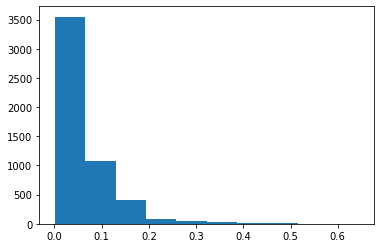

In [41]:
plt.hist(preds)

In [45]:
new_preds = (preds > 0.2).astype('int')
pd.DataFrame({'x': new_preds})['x'].value_counts()

0    5053
1     176
Name: x, dtype: int64

In [46]:
submit.loc[~test['student_id'].isin(train['student_id']), 'DEBT'] = new_preds
submit['DEBT'].value_counts()

0    34275
1     1974
Name: DEBT, dtype: int64

In [47]:
submit.to_csv('submit.csv', index=False)

Должно быть приблизительно 2200 единиц

In [31]:
from sklearn.metrics import f1_score
import numpy as np

true = np.zeros((36249))
true[:2211] = 1
preds = np.zeros((36249))
pad = 1560
preds[pad:pad+2425] = 1
f1_score(true, preds)

0.28084555651423637